In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/  # upload gson file to colab
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tinashri/brain-tumor-segmentation-datasets

In [ ]:
! unzip 'brain-tumor-segmentation-datasets.zip'

# Importing The libraries

In [2]:
import os
import cv2
import PIL
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


In [3]:
IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT = 3, 512, 512

Getting name of image files and appending it to a list.

In [4]:
X = next(os.walk('/content/data/images'))[2]
y = next(os.walk('/content/data/masks'))[2]

In [5]:
X_ids = X[:-10]
y_ids = y[:-10]

In [6]:
X_tr = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_tr = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


# Pre-processing:


In [7]:
X_train = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_train = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool)

for n, id_ in enumerate(X_ids):
    image = tf.keras.preprocessing.image.load_img(f'/content/data/images/{id_}', target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr, ).resize((256, 256))
    X_train[n] = np.array(image)

for n, id_ in enumerate(y_ids):
    image = tf.keras.preprocessing.image.load_img(f'/content/data/masks/{id_}', 
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
    y_train[n] = np.array(image)[:, :, np.newaxis]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Image view after pre-processing.

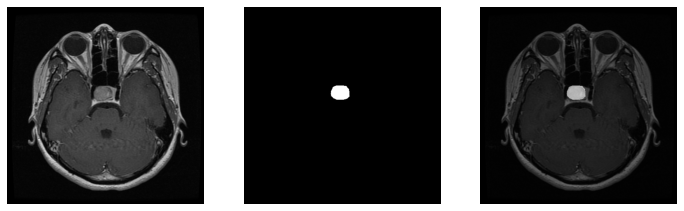

In [8]:
plt.figure(figsize=(12, 8))
img=cv2.imread('/content/data/images/1000.png')
msk=cv2.imread('/content/data/masks/1000.png')

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(msk)
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(msk,alpha=0.5)
plt.axis(False)
plt.show()

# MODEL:

## UNet model for image segmentation [Semantic].

[Paper](https://arxiv.org/abs/1505.04597)


In [9]:
inputs = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

# Training the model.

In [10]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=30)

Epoch 1/30
172/172 [==============================] - 44s 169ms/step - loss: 0.2190 - accuracy: 0.9369 - val_loss: 0.1755 - val_accuracy: 0.9503
Epoch 2/30
172/172 [==============================] - 26s 153ms/step - loss: 0.1613 - accuracy: 0.9527 - val_loss: 0.1593 - val_accuracy: 0.9503
Epoch 3/30
172/172 [==============================] - 27s 156ms/step - loss: 0.1362 - accuracy: 0.9562 - val_loss: 0.1394 - val_accuracy: 0.9548
Epoch 4/30
172/172 [==============================] - 27s 159ms/step - loss: 0.1115 - accuracy: 0.9631 - val_loss: 0.1173 - val_accuracy: 0.9611
Epoch 5/30
172/172 [==============================] - 27s 160ms/step - loss: 0.0958 - accuracy: 0.9668 - val_loss: 0.1028 - val_accuracy: 0.9658
Epoch 6/30
172/172 [==============================] - 27s 158ms/step - loss: 0.0850 - accuracy: 0.9696 - val_loss: 0.0984 - val_accuracy: 0.9676
Epoch 7/30
172/172 [==============================] - 27s 159ms/step - loss: 0.0767 - accuracy: 0.9722 - val_loss: 0.0864 - val_ac

Plotting history:

In [11]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

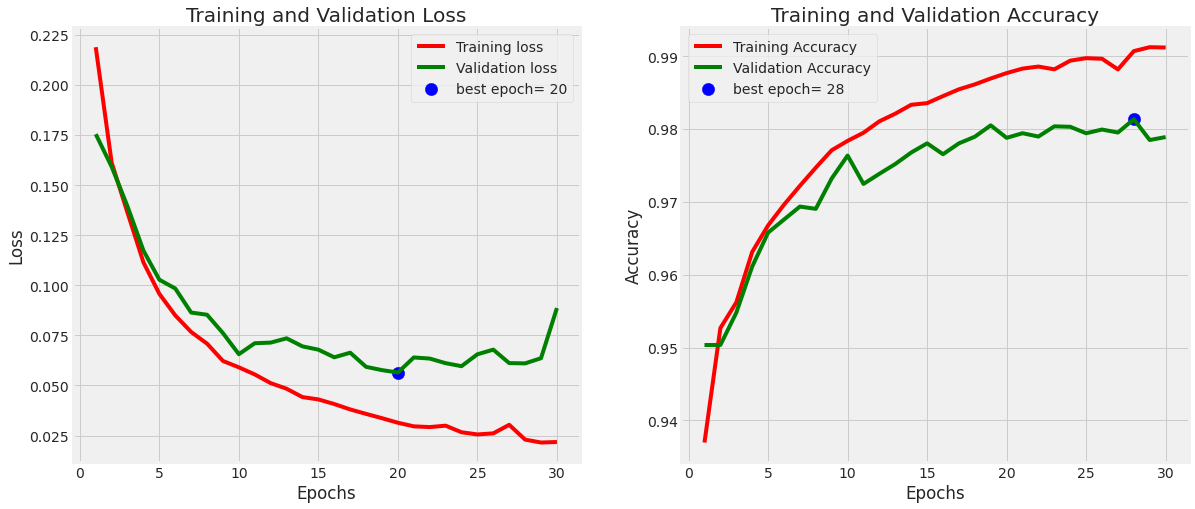

In [12]:
plot_training(history)

## PREDICTED IMAGE:

In [14]:
img = tf.keras.preprocessing.image.load_img(r"/content/image(8).jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

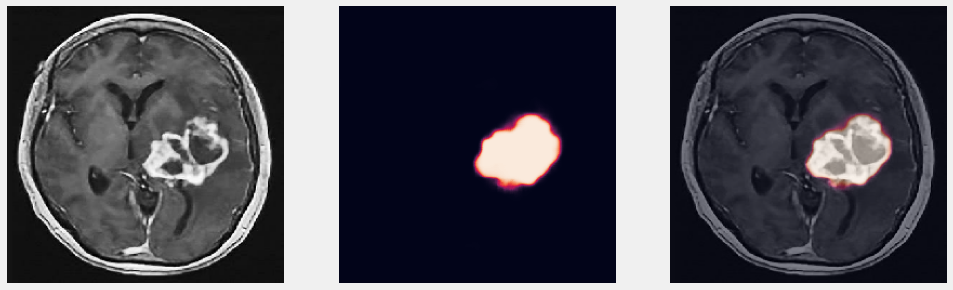

In [15]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()

In [ ]:
subject = 'Brain Tumor'
save_path = '/content/data'


save_id = str(f'{subject} model.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as /content/data/Brain Tumor model.h5


In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [3]:
uploaded_file = '/content/image1.jpg'
Seg_model = tf.keras.models.load_model("/content/Brain Tumor Seg model.h5")
img = tf.keras.preprocessing.image.load_img(uploaded_file, target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.

In [4]:
predictions = Seg_model.predict(input_array)

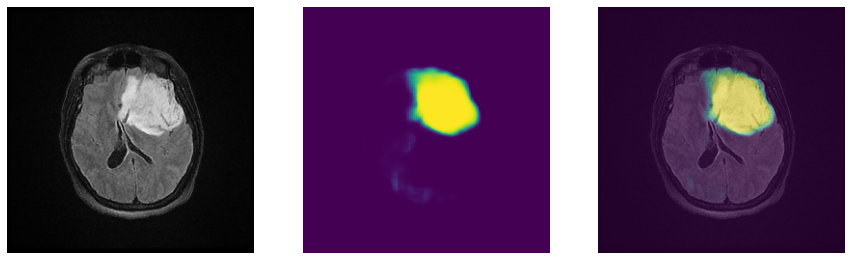

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()